<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/old%20models/full_size_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchvision.transforms.functional as F

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

fatal: destination path 'CPSC-440-Project' already exists and is not an empty directory.


'/content'

In [3]:
# !pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)



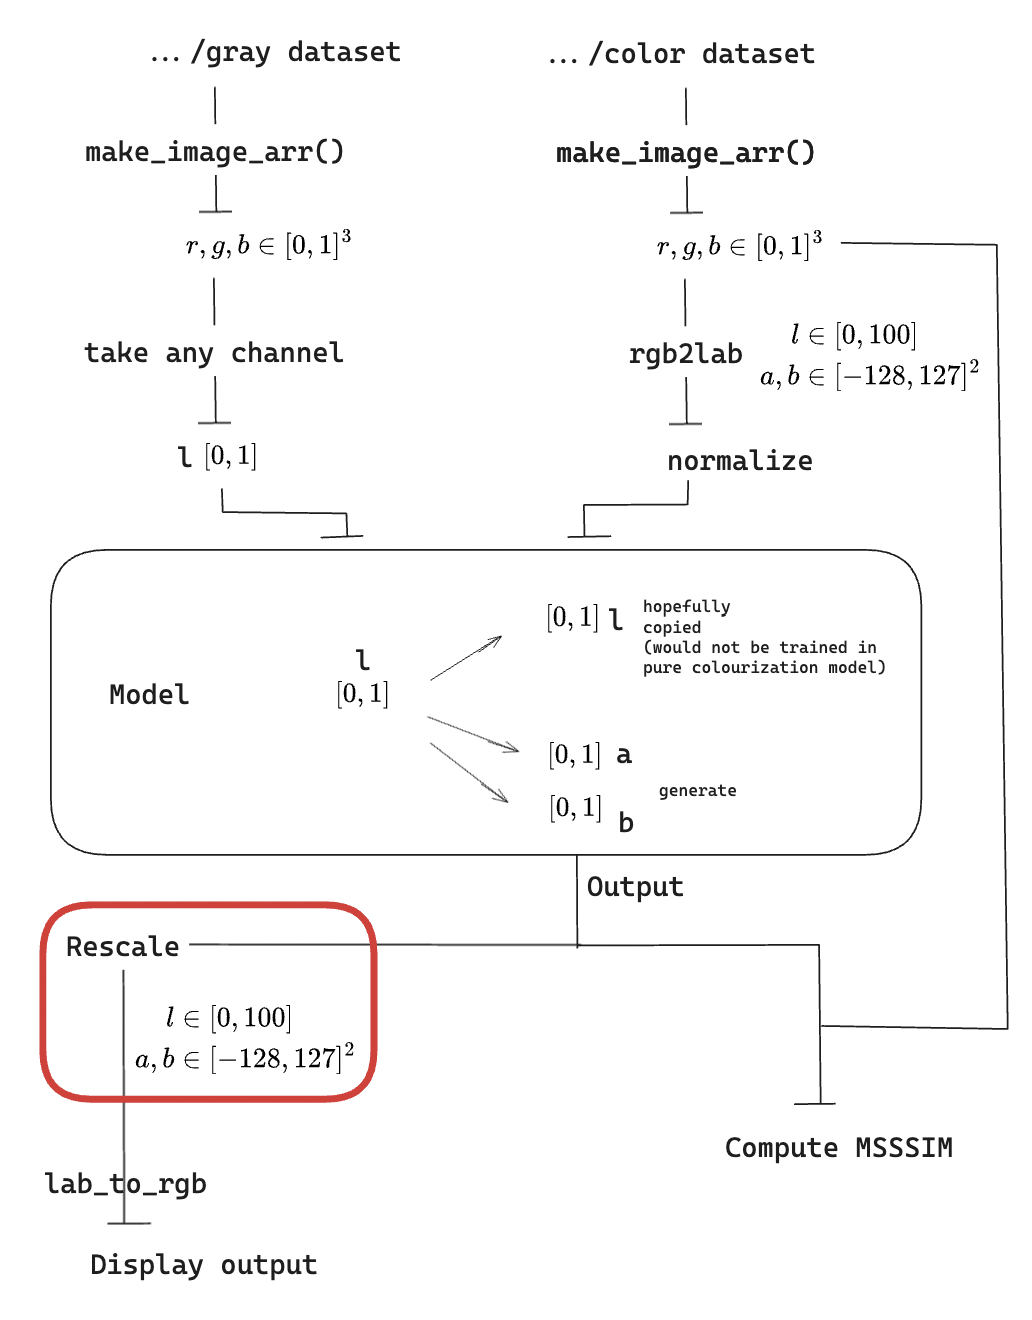

In [4]:
!pip install -q kornia


In [5]:
import kornia
import skimage

In [6]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path,cut=None,end=False):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  if cut is not None:
    files = files[:cut]
  if end:
    files = files[-1:]

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


### Making `color`

Fun fact: LAB colour space covers more than the visual spectrum so it is larger than RGB space!

See:
```python
lmin, lmax, amin, amax, bmin, bmax = 0,0,0,0,0,0
for r in np.linspace(0,1):
  for g in np.linspace(0,1):
    for b in np.linspace(0,1):
      lab = skimage.color.rgb2lab([[r,g,b]])
      lmin = min(lmin, lab[0][0])
      lmax = max(lmax, lab[0][0])
      amin = min(amin, lab[0][1])
      amax = max(amax, lab[0][1])
      bmin = min(bmin, lab[0][2])
      bmax = max(bmax, lab[0][2])

print(lmin, lmax, amin, amax, bmin, bmax)
>>> 0 100.0 -86.18302974439501 98.23305386311321 -107.85730020669489 94.47812227647823
```


In [8]:
rgb_np = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/color',cut=9600)

100%|██████████| 9600/9600 [00:13<00:00, 693.21it/s]


In [9]:
lab_np = skimage.color.rgb2lab(rgb_np)


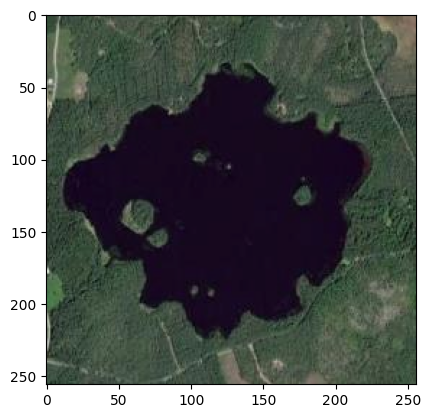

In [10]:
plt.imshow(skimage.color.lab2rgb(lab_np[0]))

In [24]:
lab_np.min()
lab_np.shape

(9600, 256, 256, 3)

In [40]:
'''
Input 4D np array
Normalize lab colours according to https://www.colourphil.co.uk/lab_lch_colour_space.shtml
'''
def squish_lab(unsquished):
  assert unsquished.shape == (9600, 256, 256, 3)
  squish = np.zeros_like(unsquished)
  squish[:,:,:,0] =  unsquished[:,:,:,0] / 100
  squish[:,:,:,1] = (unsquished[:,:,:,1] + np.ones_like(unsquished[:,:,:,1]) * 128) / 255
  squish[:,:,:,2] = (unsquished[:,:,:,2] + np.ones_like(unsquished[:,:,:,2]) * 128) / 255
  return squish

'''
Input 3D torch tensor
'''
def unsquish_lab(squished):
  try:
    unsquish = torch.zeros_like(squished,dtype='float32')
  except:
    unsquish = np.zeros_like(squished)
  unsquish[:,:,0] = squished[:,:,0] * 100
  unsquish[:,:,1] = squished[:,:,1] * 255 - 128 * np.ones_like(squished[:,:,1])
  unsquish[:,:,2] = squished[:,:,2] * 255 - 128 * np.ones_like(squished[:,:,2])
  return unsquish


In [26]:
lab_np_squish = squish_lab(lab_np)

In [27]:
lab_np_squish.min()

0.0

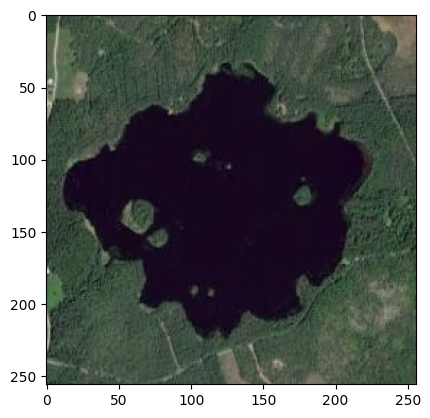

In [28]:
plt.imshow(skimage.color.lab2rgb(unsquish_lab(lab_np_squish[0])))

In [30]:
# before pushing to GPU, empty RAM
torch.cuda.empty_cache()

In [31]:
lab_np.shape

(9600, 256, 256, 3)

In [32]:
color = torch.from_numpy(np.moveaxis(lab_np, [3,1], [1,2])).to(device)

In [33]:
# free System RAM
del lab_np, lab_np_squish, rgb_np

In [34]:
color.shape

torch.Size([9600, 3, 256, 256])

### Making `gray`

In [35]:
graynp = make_image_arr('/content/CPSC-440-Project/datasets/medset_multisize/gray',cut=9600)
graynp.shape

100%|██████████| 9600/9600 [00:13<00:00, 734.33it/s]


(9600, 256, 256, 3)

In [36]:
# take one axis
graynp = np.moveaxis(graynp, [3,1], [1,2])
graynp = graynp[:, 0:1, :, :]



In [37]:
graynp.shape

(9600, 1, 256, 256)

In [38]:

# tensor to GPU
gray = torch.from_numpy(graynp).to(device)
gray.shape

torch.Size([9600, 1, 256, 256])

### All done

In [42]:
unsquish = unsquish_lab(color[0].cpu())

In [43]:
unsquish.shape

(3, 256, 256)

1385
(256, 256, 3)


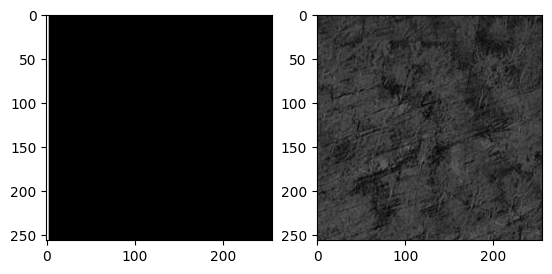

4070
(256, 256, 3)


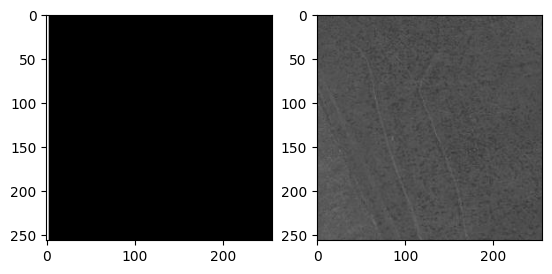

944
(256, 256, 3)


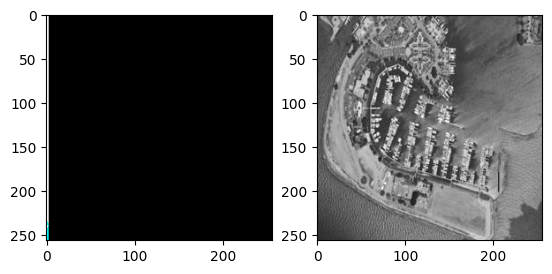

In [52]:
for i in np.random.randint(9600,size=3):
  print(i)
  plt.subplot(1,2,1)
  lab_pil = np.moveaxis(unsquish_lab(color[i].cpu()), 0,-1)
  print(lab_pil.shape)
  plt.imshow(skimage.color.lab2rgb(lab_pil))
  plt.subplot(1,2,2)
  plt.imshow(F.to_pil_image(gray[i].repeat(3,1,1)))
  plt.show()

# 3. Model
Model generated below:

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Train Model (SGD)

In [22]:
def ms_ssimloss(input, target):
  return -ms_ssim(input, target)

criterion = ms_ssimloss
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 1
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in tqdm(range(num_iterations)):
      running_loss = 0.0
      batch_indexes = torch.randint(high=9600, size=(batch_size,1))

      inputs = gray[batch_indexes].squeeze(1).to(device)
      targets = color[batch_indexes].squeeze(1).to(device)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]

[1] loss: -0.02075
Finished Training


Training set performance

i: 5683
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(552.1464, device='cuda:0', grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


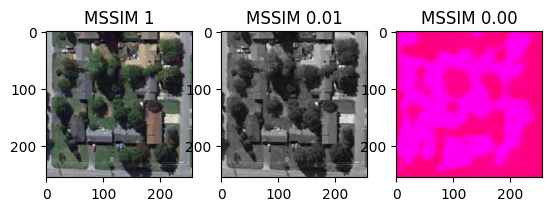

i: 1641
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(1699.9194, device='cuda:0', grad_fn=<MseLossBackward0>)


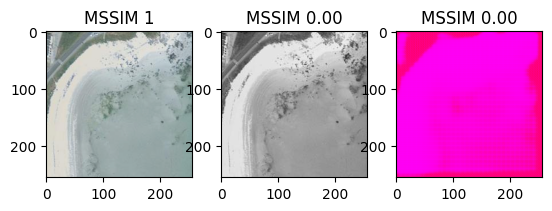

i: 5829
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(743.3161, device='cuda:0', grad_fn=<MseLossBackward0>)


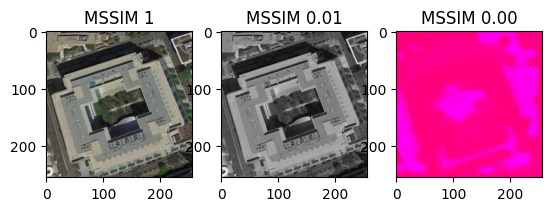

In [39]:
autoencoder.eval()
for i in np.random.randint(9600,size=3):

  # Colorize the image
  t = gray[i].unsqueeze(0).to(device)
  output = autoencoder(t)

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")
  print(nn.MSELoss()(color[i], output))

  plt.subplot(1,3,1)
  plt.imshow(F.to_pil_image(lab_to_rgb(color[i])))
  plt.title(f"MSSIM 1")

  plt.subplot(1,3,2)
  plt.imshow(F.to_pil_image(gray[i]),cmap='gray')
  # MSSSIM between original in LAB space and gray (all channels equal to lightness channel)

  # TODO check normalizations
  input_mssim = ms_ssim(color[i].unsqueeze(0).to(device), gray[i].repeat(3,1,1).unsqueeze(0).to(device), data_range=1, size_average=True) # return scalar
  plt.title(f"MSSIM {input_mssim:.2f}")

  plt.subplot(1,3,3)
  plt.imshow(F.to_pil_image((output.squeeze())))
  output_mssim = ms_ssim(color[i].unsqueeze(0).to(device), output.to(device), data_range=1, size_average=True) # return scalar
  plt.title(f"MSSIM {output_mssim:.2f}")

  plt.show()



In [38]:
output

tensor([[[[0.9681, 0.9954, 0.9957,  ..., 0.9946, 0.9930, 0.9652],
          [0.9879, 0.9991, 0.9992,  ..., 0.9990, 0.9985, 0.9909],
          [0.9828, 0.9994, 0.9991,  ..., 0.9990, 0.9984, 0.9921],
          ...,
          [0.9858, 0.9989, 0.9983,  ..., 0.9988, 0.9974, 0.9861],
          [0.9814, 0.9988, 0.9982,  ..., 0.9988, 0.9979, 0.9864],
          [0.9180, 0.9864, 0.9853,  ..., 0.9882, 0.9836, 0.9611]],

         [[0.0997, 0.0270, 0.0214,  ..., 0.0319, 0.0335, 0.1151],
          [0.0369, 0.0021, 0.0035,  ..., 0.0025, 0.0055, 0.0177],
          [0.0275, 0.0025, 0.0014,  ..., 0.0039, 0.0040, 0.0192],
          ...,
          [0.0381, 0.0029, 0.0054,  ..., 0.0032, 0.0064, 0.0256],
          [0.0343, 0.0042, 0.0040,  ..., 0.0039, 0.0046, 0.0260],
          [0.1035, 0.0217, 0.0254,  ..., 0.0208, 0.0290, 0.0770]],

         [[0.5153, 0.5676, 0.4155,  ..., 0.5409, 0.4565, 0.4867],
          [0.6424, 0.4832, 0.5293,  ..., 0.4852, 0.4979, 0.4505],
          [0.5812, 0.5878, 0.4080,  ..., 0

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/models/ssimloss/decoder_weights_256_4epochnegssim')

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/ssimloss/full_size_encoder_weights_256_4epochnegssim')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
%cd CPSC-440-Project

/content/CPSC-440-Project


In [ ]:

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!git add .

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   models/ssimloss/decoder_weights_256_4epochnegssim
	new file:   models/ssimloss/full_size_encoder_weights_256_4epochnegssim



In [ ]:
!git commit -m "256x256 model weights with negative msssim loss, trained 4 epochs"

[main e82166f39] 256x256 model weights with negative msssim loss, trained 4 epochs
 2 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/ssimloss/decoder_weights_256_4epochnegssim
 create mode 100644 models/ssimloss/full_size_encoder_weights_256_4epochnegssim


In [ ]:
!git push --force

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 16 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 2.81 MiB | 4.31 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/StuartLiv/CPSC-440-Project
   423455dcb..e82166f39  main -> main


# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!